In [2]:
import os, sys
from pathlib import Path

# Get the absolute path to the project root (two levels up from this notebook)
project_root = Path(__file__).resolve().parents[2] if "__file__" in globals() else Path(os.getcwd()).parents[1]
sys.path.append(str(project_root))

print("Project root added to path:", project_root)


import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.preprocessing.preprocess import load_raw_data, clean_data, train_val_test_split
from src.models.baseline import (
    majority_class_baseline,
    logistic_regression_pipeline,
    random_forest_pipeline,
    gradient_boosting_pipeline,
)



Project root added to path: /home/rolljake/cmse492_aml/cmse492_project


# Import and Cleaning Data

In [3]:
DATA_PATH = Path("../../data/raw/adult.data")

df_raw = load_raw_data(DATA_PATH)

print("Raw shape:", df_raw.shape)
display(df_raw.head())
display(df_raw.dtypes)


Raw shape: (32561, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object

In [4]:
df_clean = clean_data(df_raw)
print("After cleaning:", df_clean.shape)
display(df_clean.head())

processed_dir = Path("../../data/processed")
processed_dir.mkdir(parents=True, exist_ok=True)

sample_path = processed_dir / "adult_sample.csv"
df_clean.sample(1000, random_state=0).to_csv(sample_path, index=False)
print("Saved sample:", sample_path)


After cleaning: (32561, 101)


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income_binary,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia,native_country_nan
0,39,77516,13,2174,0,40,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,50,83311,13,0,0,13,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,38,215646,9,0,0,40,0,False,False,True,...,False,False,False,False,False,False,True,False,False,False
3,53,234721,7,0,0,40,0,False,False,True,...,False,False,False,False,False,False,True,False,False,False
4,28,338409,13,0,0,40,0,False,False,True,...,False,False,False,False,False,False,False,False,False,False


Saved sample: ../../data/processed/adult_sample.csv


# EDA

Saved: ../../figures/feature_distributions.png


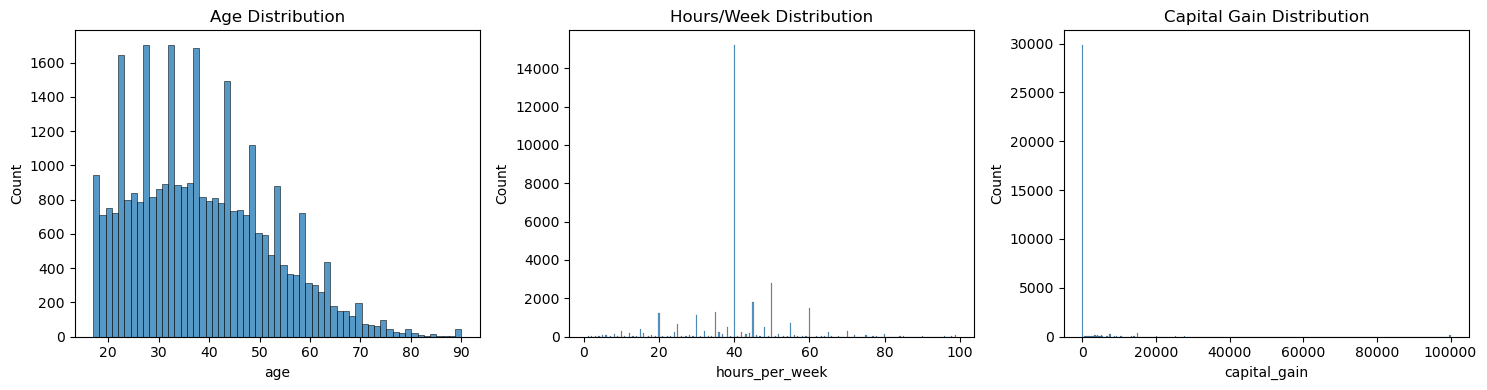

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

sns.histplot(df_clean["age"], kde=False, ax=axes[0])
axes[0].set_title("Age Distribution")

sns.histplot(df_clean["hours_per_week"], kde=False, ax=axes[1])
axes[1].set_title("Hours/Week Distribution")

sns.histplot(df_clean["capital_gain"], kde=False, ax=axes[2])
axes[2].set_title("Capital Gain Distribution")

plt.tight_layout()

figures_dir = Path("../../figures")
figures_dir.mkdir(parents=True, exist_ok=True)
out_path = figures_dir / "feature_distributions.png"
plt.savefig(out_path, dpi=300)
print("Saved:", out_path)
plt.show()


Saved: ../../figures/class_balance.png


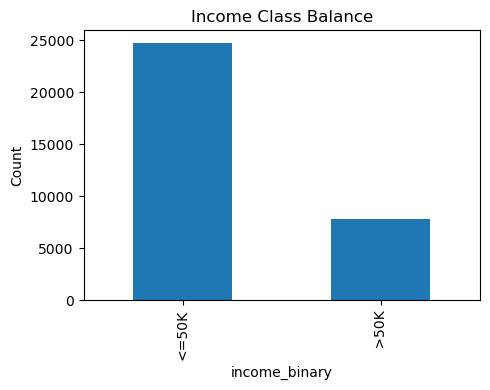

In [6]:
fig, ax = plt.subplots(figsize=(5,4))
df_clean["income_binary"].value_counts().plot(kind="bar", ax=ax)
ax.set_xticklabels(["<=50K"," >50K"])
ax.set_ylabel("Count")
ax.set_title("Income Class Balance")
plt.tight_layout()
out_path = figures_dir / "class_balance.png"
plt.savefig(out_path, dpi=300)
print("Saved:", out_path)
plt.show()


Saved: ../../figures/pair_relationships.png


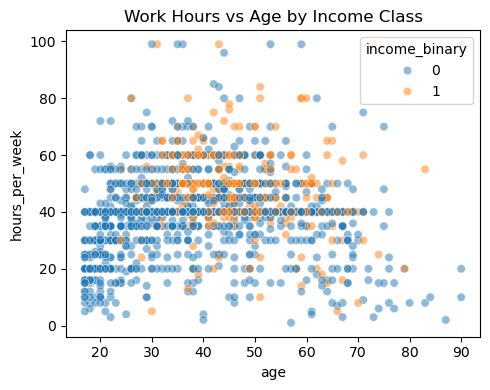

In [7]:
fig, ax = plt.subplots(figsize=(5,4))
sns.scatterplot(
    data=df_clean.sample(2000, random_state=0),
    x="age",
    y="hours_per_week",
    hue="income_binary",
    alpha=0.5,
    ax=ax
)
ax.set_title("Work Hours vs Age by Income Class")
plt.tight_layout()
out_path = figures_dir / "pair_relationships.png"
plt.savefig(out_path, dpi=300)
print("Saved:", out_path)
plt.show()


Saved: ../../figures/missing_values.png


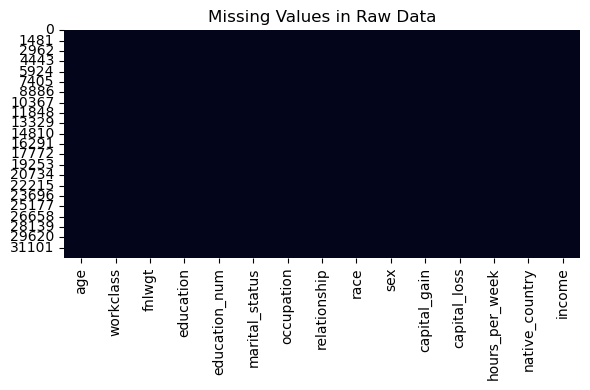

In [8]:
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(df_raw.isna(), cbar=False, ax=ax)
ax.set_title("Missing Values in Raw Data")
plt.tight_layout()
out_path = figures_dir / "missing_values.png"
plt.savefig(out_path, dpi=300)
print("Saved:", out_path)
plt.show()


# Model Analysis

In [9]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_clean)
print("Train:", X_train.shape,
      "Val:", X_val.shape,
      "Test:", X_test.shape)


Train: (22792, 100) Val: (3256, 100) Test: (6513, 100)


In [10]:
majority_acc_val, majority_label = majority_class_baseline(y_train, y_val)
print("Majority-class baseline (val) accuracy:", majority_acc_val)
print("Predicted class for everyone:", majority_label)


Majority-class baseline (val) accuracy: 0.7592137592137592
Predicted class for everyone: 0


In [11]:
logreg_acc_val, logreg_report_val, logreg_clf = logistic_regression_pipeline(
    X_train, X_val, y_train, y_val
)
print("Logistic Regression (val) accuracy:", logreg_acc_val)
print(logreg_report_val)

Logistic Regression (val) accuracy: 0.8455159705159705
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2472
           1       0.71      0.60      0.65       784

    accuracy                           0.85      3256
   macro avg       0.80      0.76      0.78      3256
weighted avg       0.84      0.85      0.84      3256



In [12]:
rf_acc_val, rf_report_val, rf_clf = random_forest_pipeline(
    X_train, X_val, y_train, y_val
)
print("Random Forest (val) accuracy:", rf_acc_val)
print(rf_report_val)

gb_acc_val, gb_report_val, gb_clf = gradient_boosting_pipeline(
    X_train, X_val, y_train, y_val
)
print("Gradient Boosting (val) accuracy:", gb_acc_val)
print(gb_report_val)

results = [
    {"model": "Majority Class",      "split": "val", "accuracy": majority_acc_val},
    {"model": "Logistic Regression", "split": "val", "accuracy": logreg_acc_val},
    {"model": "Random Forest",       "split": "val", "accuracy": rf_acc_val},
    {"model": "Gradient Boosting",   "split": "val", "accuracy": gb_acc_val},
]

results_df = pd.DataFrame(results)
display(results_df)

# Optional: save to figures/ for LaTeX table later
results_df.to_csv(figures_dir / "model_comparison_val.csv", index=False)
print("Saved:", figures_dir / "model_comparison_val.csv")

Random Forest (val) accuracy: 0.8535012285012284
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      2472
           1       0.72      0.64      0.68       784

    accuracy                           0.85      3256
   macro avg       0.81      0.78      0.79      3256
weighted avg       0.85      0.85      0.85      3256

Gradient Boosting (val) accuracy: 0.8707002457002457
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      2472
           1       0.78      0.64      0.70       784

    accuracy                           0.87      3256
   macro avg       0.84      0.79      0.81      3256
weighted avg       0.87      0.87      0.87      3256



,model,split,accuracy
0,Majority Class,val,0.759214
1,Logistic Regression,val,0.845516
2,Random Forest,val,0.853501
3,Gradient Boosting,val,0.870700


Saved: ../../figures/model_comparison_val.csv


In [13]:
import pandas as pd

table_data = [
    {
        "Model": "Logistic Regression",
        "Parameters": "Coefficients + intercept",
        "Hyperparameters": "max_iter=1000, penalty='l2', solver='lbfgs'",
        "Loss Function": "Binary cross-entropy (log loss)",
        "Regularization": "L2 (ridge) penalty on weights"
    },
    {
        "Model": "Random Forest",
        "Parameters": "200 trees, node splits",
        "Hyperparameters": "n_estimators=200, max_depth=None, criterion='gini', random_state=42",
        "Loss Function": "Gini impurity reduction at splits",
        "Regularization": "Ensemble averaging, bootstrap samples, feature subsampling"
    },
    {
        "Model": "Gradient Boosting",
        "Parameters": "200 boosted trees",
        "Hyperparameters": "n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42",
        "Loss Function": "Additive logistic / deviance loss",
        "Regularization": "Shrinkage (learning rate), tree depth limits"
    }
]

df_models = pd.DataFrame(table_data)
display(df_models)

,Model,Parameters,Hyperparameters,Loss Function,Regularization
0,Logistic Regression,Coefficients + intercept,"max_iter=1000, penalty='l2', solver='lbfgs'",Binary cross-entropy (log loss),L2 (ridge) penalty on weights
1,Random Forest,"200 trees, node splits","n_estimators=200, max_depth=None, criterion='g...",Gini impurity reduction at splits,"Ensemble averaging, bootstrap samples, feature..."
2,Gradient Boosting,200 boosted trees,"n_estimators=200, learning_rate=0.1, max_depth...",Additive logistic / deviance loss,"Shrinkage (learning rate), tree depth limits"


# Time Analysis and Feature Importance

In [13]:
import time

def measure_time(model, X_train, y_train, X_val):
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start

    start = time.time()
    model.predict(X_val[:1])
    infer_time = (time.time() - start) * 1000  # ms per sample

    return train_time, infer_time

logreg_train, logreg_infer = measure_time(logreg_clf, X_train, y_train, X_val)
rf_train, rf_infer         = measure_time(rf_clf,     X_train, y_train, X_val)
gb_train, gb_infer         = measure_time(gb_clf,     X_train, y_train, X_val)

print("Logistic Regression:", logreg_train, logreg_infer)
print("Random Forest:", rf_train, rf_infer)
print("Gradient Boosting:", gb_train, gb_infer)


Logistic Regression: 1.516491174697876 3.354787826538086
Random Forest: 1.2404186725616455 101.73511505126953
Gradient Boosting: 7.930912256240845 4.852056503295898


Encoded shape (train): (22792, 100)
Example feature names: ['age' 'fnlwgt' 'education_num' 'capital_gain' 'capital_loss'
 'hours_per_week' 'workclass_Local-gov' 'workclass_Never-worked'
 'workclass_Private' 'workclass_Self-emp-inc']


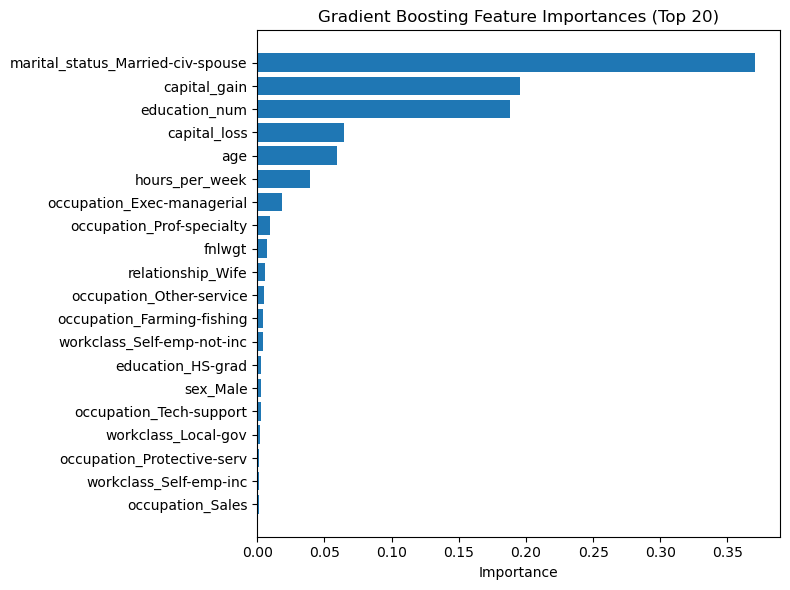

Saved: ../../figures/feature_importance_gb.png


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier

df_train = X_train.copy()
df_test = X_test.copy()

for df in (df_train, df_test):
    if "income" in df.columns:
        df.drop(columns=["income"], inplace=True)

# One-hot encode train
df_train_enc = pd.get_dummies(df_train, drop_first=True)

df_test_enc = pd.get_dummies(df_test, drop_first=True)
df_test_enc = df_test_enc.reindex(columns=df_train_enc.columns, fill_value=0)

X_train_enc = df_train_enc.values
X_test_enc = df_test_enc.values
feature_names = df_train_enc.columns.to_numpy()

print("Encoded shape (train):", X_train_enc.shape)
print("Example feature names:", feature_names[:10])

gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
)

gb_model.fit(X_train_enc, y_train)

importances = gb_model.feature_importances_
n_features = len(importances)

idx = np.argsort(importances)[-20:]

plt.figure(figsize=(8, 6))
plt.barh(range(len(idx)), importances[idx])
plt.yticks(range(len(idx)), feature_names[idx])
plt.xlabel("Importance")
plt.title("Gradient Boosting Feature Importances (Top 20)")
plt.tight_layout()

out_path = figures_dir / "feature_importance_gb.png"
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved:", out_path)


# RFE

Encoded shape: (22792, 100)
Example feature names: ['age' 'fnlwgt' 'education_num' 'capital_gain' 'capital_loss'
 'hours_per_week' 'workclass_Local-gov' 'workclass_Never-worked'
 'workclass_Private' 'workclass_Self-emp-inc']


/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please


Top features selected by RFE:
 - education_1st-4th
 - education_5th-6th
 - education_7th-8th
 - education_Doctorate
 - education_Prof-school
 - marital_status_Married-AF-spouse
 - marital_status_Married-civ-spouse
 - occupation_Exec-managerial
 - occupation_Handlers-cleaners
 - occupation_Other-service
 - occupation_Priv-house-serv
 - occupation_Prof-specialty
 - relationship_Other-relative
 - relationship_Own-child
 - native_country_China
 - native_country_Columbia
 - native_country_Dominican-Republic
 - native_country_El-Salvador
 - native_country_Mexico
 - native_country_Puerto-Rico


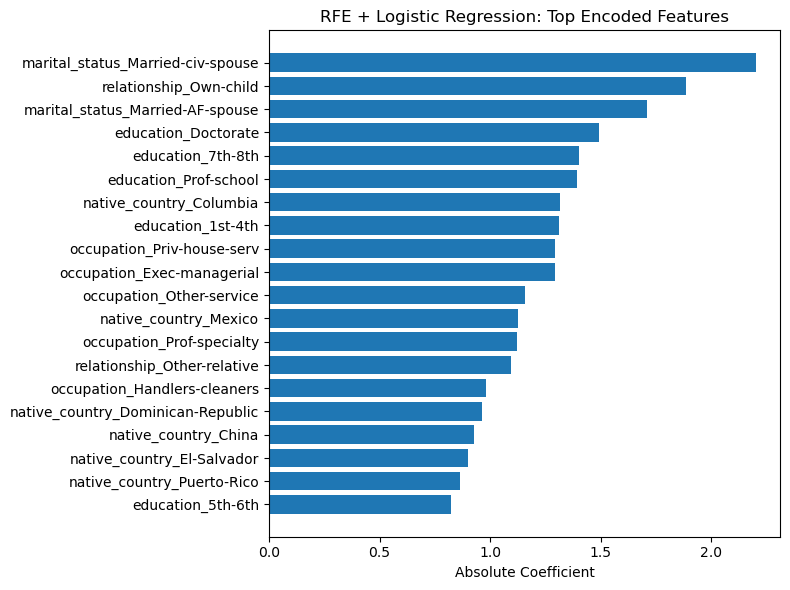


Saved RFE figure to: ../../figures/rfe_logreg_importance.png


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE


df_train = X_train.copy()

if "income" in df_train.columns:
    df_train = df_train.drop(columns=["income"])

df_encoded = pd.get_dummies(df_train, drop_first=True)

X_train_enc = df_encoded.values
feature_names = df_encoded.columns.to_numpy()

print("Encoded shape:", X_train_enc.shape)
print("Example feature names:", feature_names[:10])

# RFE
log_reg = LogisticRegression(max_iter=1000)

n_features_to_select = 20
rfe = RFE(estimator=log_reg, n_features_to_select=n_features_to_select, step=1)
rfe.fit(X_train_enc, y_train)

selected_mask = rfe.support_
selected_features = feature_names[selected_mask]

print("\nTop features selected by RFE:")
for name in selected_features:
    print(" -", name)

coefs = np.abs(rfe.estimator_.coef_.ravel()) 

order = np.argsort(coefs)

plt.figure(figsize=(8, 6))
plt.barh(range(len(order)), coefs[order])
plt.yticks(range(len(order)), selected_features[order])
plt.xlabel("Absolute Coefficient")
plt.title("RFE + Logistic Regression: Top Encoded Features")
plt.tight_layout()

out_path = figures_dir / "rfe_logreg_importance.png"
plt.savefig(out_path, dpi=300)
plt.show()

print("\nSaved RFE figure to:", out_path)


# SHAP

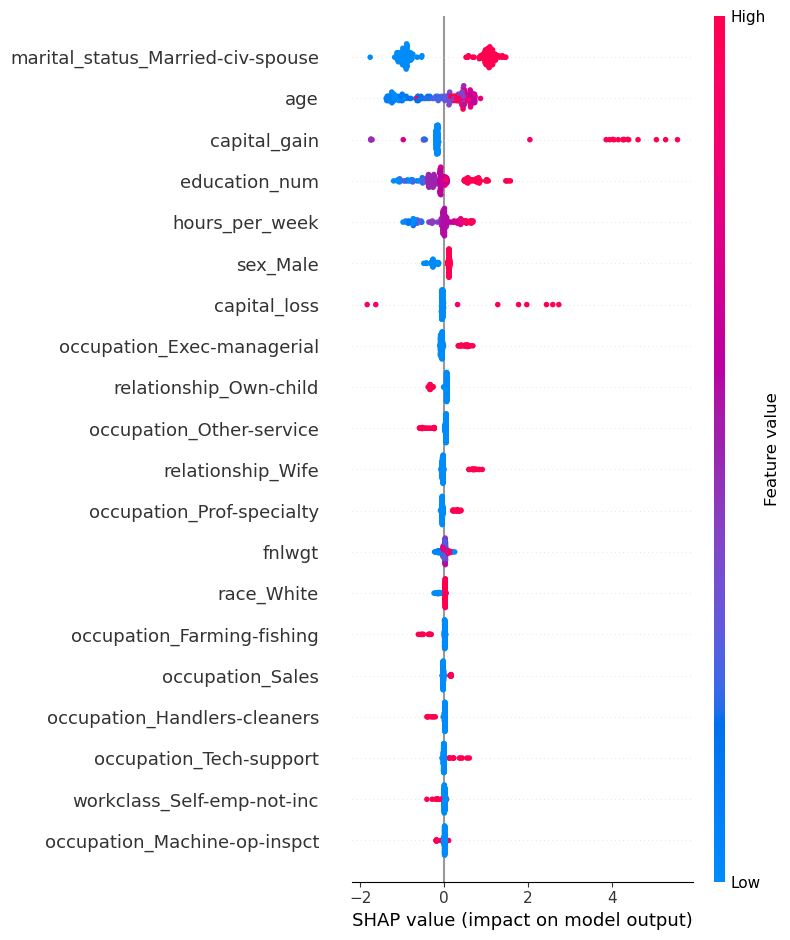

Saved SHAP summary plot to: ../../figures/shap_summary_gb.png


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import shap

explainer_gb = shap.TreeExplainer(gb_model)

sample_size = min(200, X_test_enc.shape[0])
sample_indices = np.random.choice(X_test_enc.shape[0], sample_size, replace=False)
X_test_sample = X_test_enc[sample_indices]

shap_values_gb = explainer_gb.shap_values(X_test_sample)

plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_gb,
    X_test_sample,
    feature_names=feature_names,
    show=False
)
plt.tight_layout()

out_path = figures_dir / "shap_summary_gb.png"
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved SHAP summary plot to:", out_path)

# Learning Curve for Gradient Boost

Train encoded shape: (22792, 100)
Val encoded shape: (3256, 100)


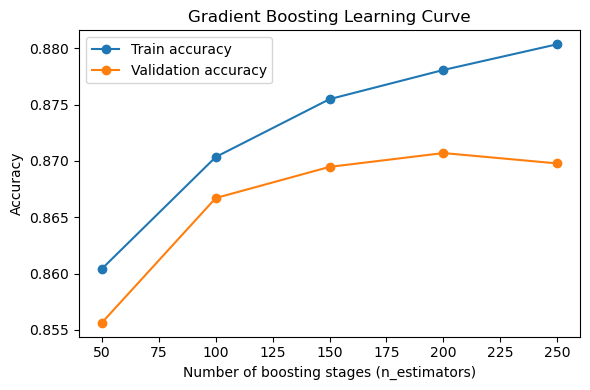

Saved learning curve to: ../../figures/learning_curve_gb.png


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

df_train = X_train.copy()
df_val = X_val.copy()

for df in (df_train, df_val):
    if "income" in df.columns:
        df.drop(columns=["income"], inplace=True)

df_train_enc = pd.get_dummies(df_train, drop_first=True)
df_val_enc = pd.get_dummies(df_val, drop_first=True)
df_val_enc = df_val_enc.reindex(columns=df_train_enc.columns, fill_value=0)

X_train_enc = df_train_enc.values
X_val_enc = df_val_enc.values

print("Train encoded shape:", X_train_enc.shape)
print("Val encoded shape:", X_val_enc.shape)

n_estimators_list = [50, 100, 150, 200, 250]
train_acc = []
val_acc = []

for n in n_estimators_list:
    gb = GradientBoostingClassifier(
        n_estimators=n,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
    )
    gb.fit(X_train_enc, y_train)

    y_train_pred = gb.predict(X_train_enc)
    y_val_pred = gb.predict(X_val_enc)

    train_acc.append(accuracy_score(y_train, y_train_pred))
    val_acc.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(6, 4))
plt.plot(n_estimators_list, train_acc, marker="o", label="Train accuracy")
plt.plot(n_estimators_list, val_acc, marker="o", label="Validation accuracy")
plt.xlabel("Number of boosting stages (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Gradient Boosting Learning Curve")
plt.legend()
plt.tight_layout()

out_path = figures_dir / "learning_curve_gb.png"
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved learning curve to:", out_path)


# Gradient Boost Confusion Matrix

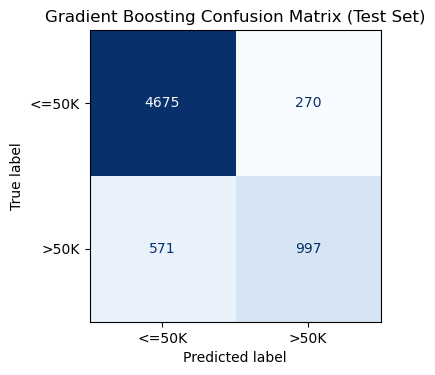

Saved confusion matrix to: ../../figures/confusion_matrix_gb.png


In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

df_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

df_train_full = df_train_full.copy()
df_test = X_test.copy()

for df in (df_train_full, df_test):
    if "income" in df.columns:
        df.drop(columns=["income"], inplace=True)

df_train_full_enc = pd.get_dummies(df_train_full, drop_first=True)
df_test_enc = pd.get_dummies(df_test, drop_first=True)
df_test_enc = df_test_enc.reindex(columns=df_train_full_enc.columns, fill_value=0)

X_train_full_enc = df_train_full_enc.values
X_test_enc = df_test_enc.values

gb_final = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
)
gb_final.fit(X_train_full_enc, y_train_full)
y_test_pred = gb_final.predict(X_test_enc)

cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["<=50K", ">50K"])

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Gradient Boosting Confusion Matrix (Test Set)")
plt.tight_layout()

out_path = figures_dir / "confusion_matrix_gb.png"
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved confusion matrix to:", out_path)
